***
## Table of Contents
<br>
  <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">1. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">2. Oversampling </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">3. Undersampling</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">4.Feature Transformation with feature selection</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">5.Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#5.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display,clear_output,HTML
import warnings
warnings.filterwarnings("ignore")

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
warnings.simplefilter("ignore", DeprecationWarning)
import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import metrics



from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score,matthews_corrcoef

from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats

Using TensorFlow backend.


In [2]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
#     m['Features']=m['Features'].str.replace("dom_function_","")
#     m['Features']=m['Features'].str.replace("js_function_","")
#     m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
#     m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

In [3]:
def model_build(model,X_train,Y_train,X_test,Y_test,tree=False,feat=None):
    
    y_pred_train=model.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    
    print("Accuracy of the model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=model.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the model for test data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    mcc=matthews_corrcoef(Y_test,y_pred_test)
    if tree==True:
        feat_impt_plot(model.feature_importances_,feat)
        return model,cm_train,cm_test,acc_train,acc_test,roc_auc,model.feature_importances_,mcc
    
    return model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)

    return model_build(knn,X_train,Y_train,X_test,Y_test)

def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression()
    log.fit(X_train,Y_train)
    
    return model_build(log,X_train,Y_train,X_test,Y_test)

def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier()
    rf.fit(X_train,Y_train)

    
    return model_build(rf,X_train,Y_train,X_test,Y_test,True,feat)

def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier()
    ada.fit(X_train,Y_train)
    
    return model_build(ada,X_train,Y_train,X_test,Y_test,True,feat)

def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier()
    gbc.fit(X_train,Y_train)
    
    return model_build(gbc,X_train,Y_train,X_test,Y_test,True,feat)

def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier()
    ext_tree.fit(X_train,Y_train)
    
    return model_build(ext_tree,X_train,Y_train,X_test,Y_test,True,feat)

def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier()
    bagging.fit(X_train,Y_train)
    
    return model_build(bagging,X_train,Y_train,X_test,Y_test)

def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    mcc=matthews_corrcoef(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

In [5]:
columns=['http_header_cache-control_set_max-age',
 'http_header_cache-control_set_must-revalidate',
 'http_header_cache-control_set_no-cache',
 'http_header_cache-control_set_no-store',
 'http_header_cache-control_set_private',
 'http_header_cache-control_set_public',
 'http_header_content-encoding_gzip',
 'http_header_content-language_text/html',
 'http_header_content-length',
 'http_header_server_apache',
 'http_header_server_nginx',
 'http_header_strict-transport-security_max-age',
 'http_header_x-cintent-type-options_nosniff',
 'http_header_x-xss-enabled','Target','domain']

In [6]:
df=pd.read_csv('Modified_http.csv',usecols=columns)

df.rename(columns={'Malicious':'Target'},inplace=True)
df.fillna(value=0,inplace=True)

cookies=[columns for columns in df.columns if 'number' in columns]
df.drop(cookies,axis=1,inplace=True)

df=df[df['domain']!=0]

df.sort_values(by='Target',inplace=True,ascending=False)
df.drop_duplicates(['domain'], keep='first',inplace=True)

df=df.sample(frac=1,random_state=0)
df.set_index(['domain'],drop=True,inplace=True)
print("Shape of our dataset:",df.shape)

Shape of our dataset: (45856, 15)


In [7]:
df.Target.value_counts()

0    39835
1     6021
Name: Target, dtype: int64

In [8]:
train=df.iloc[:36684,:]
train_X=train.iloc[:,train.columns!='Target'].values
train_Y=train.Target.values

scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

In [9]:
test=df.iloc[36684:,:]
test_X=test.iloc[:,test.columns!='Target'].values
test_Y=test.Target.values
scaled_X_test=scaler.transform(test_X)

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [10]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC'])

In [11]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,columns[:-2])
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.900610620434
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28849  3004    31853
True         642  4189     4831
__all__    29491  7193    36684

Accuracy of the model for test data is: 0.902093327519
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7244   738     7982
True         160  1030     1190
__all__     7404  1768     9172



Logistic Regression
Accuracy of the model for training data is: 0.872860102497
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29369  2484    31853
True        2180  2651     4831
__all__    31549  5135    36684

Accuracy of the model for test data is: 0.872764936764
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7361   621     7982
True         546   644     1190
__all__     7907  1265     9172



RandomForest Classifier
Accuracy of the model for training data is: 0.907016683023
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28890  2963    31853
True         448  4383     4831
__all__    29338  7346    36684

Accuracy of the model for test data is: 0.901875272569
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7229   753     7982
True         147  1043     1190
__all__     7376  1796     9172



Adaoost Classifier
Accuracy of the model for training data is: 0.888997928252
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29184  2669    31853
True        1403  3428     4831
__all__    30587  6097    36684

Accuracy of the model for test data is: 0.891408634976
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7325   657     7982
True         339   851     1190
__all__     7664  1508     9172



GradientBoosting Classifier
Accuracy of the model for training data is: 0.896030967179
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28931  2922    31853
True         892  3939     4831
__all__    29823  6861    36684

Accuracy of the model for test data is: 0.898059310946
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7271   711     7982
True         224   966     1190
__all__     7495  1677     9172



ExtraTree Classifier
Accuracy of the model for training data is: 0.908488714426
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28912  2941    31853
True         416  4415     4831
__all__    29328  7356    36684

Accuracy of the model for test data is: 0.900021805495
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7214   768     7982
True         149  1041     1190
__all__     7363  1809     9172



Bagging Classifier
Accuracy of the model for training data is: 0.906662305092
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28889  2964    31853
True         460  4371     4831
__all__    29349  7335    36684

Accuracy of the model for test data is: 0.901875272569
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7228   754     7982
True         146  1044     1190
__all__     7374  1798     9172



Neural Network-1
The accuracy of the model on training data is: 0.886299204013


Predicted  False  True  __all__
Actual                         
False      28639  3214    31853
True         957  3874     4831
__all__    29596  7088    36684

The accuracy of the model on test data is: 0.891517662451


Predicted  False  True  __all__
Actual                         
False       7215   767     7982
True         228   962     1190
__all__     7443  1729     9172

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [12]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [13]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.900611,4189.0,28849.0,3004.0,642.0,0.094308,0.132892
LogisticRegression,0.872860,2651.0,29369.0,2484.0,2180.0,0.077983,0.451252
RandomForestClassifier,0.907017,4383.0,28890.0,2963.0,448.0,0.093021,0.092734
AdaBoostClassifier,0.888998,3428.0,29184.0,2669.0,1403.0,0.083791,0.290416
GradientBoostingClassifier,0.896031,3939.0,28931.0,2922.0,892.0,0.091734,0.184641
ExtraTreeClassifier,0.908489,4415.0,28912.0,2941.0,416.0,0.092330,0.086111
BaggingClassifier,0.906662,4371.0,28889.0,2964.0,460.0,0.093052,0.095218
Neural Network-1,0.886299,3874.0,28639.0,3214.0,957.0,0.100901,0.198096


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC
index,,,,,,,,,
KNeighborsClassifier,0.902093,1030.0,7244.0,738.0,160.0,0.092458,0.134454,0.886544,0.658543
LogisticRegression,0.872765,644.0,7361.0,621.0,546.0,0.077800,0.458824,0.731688,0.451557
RandomForestClassifier,0.901875,1043.0,7229.0,753.0,147.0,0.094337,0.123529,0.891067,0.662287
AdaBoostClassifier,0.891409,851.0,7325.0,657.0,339.0,0.082310,0.284874,0.816408,0.573691
GradientBoostingClassifier,0.898059,966.0,7271.0,711.0,224.0,0.089075,0.188235,0.861345,0.628244
ExtraTreeClassifier,0.900022,1041.0,7214.0,768.0,149.0,0.096216,0.125210,0.889287,0.657480
BaggingClassifier,0.901875,1044.0,7228.0,754.0,146.0,0.094463,0.122689,0.891424,0.662614
Neural Network-1,0.891518,962.0,7215.0,767.0,228.0,0.096091,0.191597,0.891424,0.611967


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [14]:
feat_impt_plot(np.average(feat_imp,axis=0),columns[:-2])

### <a id='2' style="text-decoration : none; color : #000000;"> 2. OverSampling </a>

In [15]:
sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(scaled_X_train,train_Y)

/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning:

Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.



In [16]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [17]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns[:-2])
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.669152042194
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      30944    909    31853
True       20168  11685    31853
__all__    51112  12594    63706

Accuracy of the model for test data is: 0.887701700829
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7729   253     7982
True         777   413     1190
__all__     8506   666     9172



Logistic Regression
Accuracy of the model for training data is: 0.828634665495
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      26278   5575    31853
True        5342  26511    31853
__all__    31620  32086    63706

Accuracy of the model for test data is: 0.828499781945
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6608  1374     7982
True         199   991     1190
__all__     6807  2365     9172



RandomForest Classifier
Accuracy of the model for training data is: 0.919411044486
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      28693   3160    31853
True        1974  29879    31853
__all__    30667  33039    63706

Accuracy of the model for test data is: 0.887810728304
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7077   905     7982
True         124  1066     1190
__all__     7201  1971     9172



Adaoost Classifier
Accuracy of the model for training data is: 0.855774966251
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      26155   5698    31853
True        3490  28363    31853
__all__    29645  34061    63706

Accuracy of the model for test data is: 0.831443523768
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6573  1409     7982
True         137  1053     1190
__all__     6710  2462     9172



GradientBoosting Classifier
Accuracy of the model for training data is: 0.883072238094
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      27481   4372    31853
True        3077  28776    31853
__all__    30558  33148    63706

Accuracy of the model for test data is: 0.868730920192
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6902  1080     7982
True         124  1066     1190
__all__     7026  2146     9172



ExtraTree Classifier
Accuracy of the model for training data is: 0.922362100901
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      28741   3112    31853
True        1834  30019    31853
__all__    30575  33131    63706

Accuracy of the model for test data is: 0.885412123855
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7053   929     7982
True         122  1068     1190
__all__     7175  1997     9172



Bagging Classifier
Accuracy of the model for training data is: 0.919316861834
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      28698   3155    31853
True        1985  29868    31853
__all__    30683  33023    63706

Accuracy of the model for test data is: 0.886611426079
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7064   918     7982
True         122  1068     1190
__all__     7186  1986     9172



Neural Network-1
The accuracy of the model on training data is: 0.886823847038


Predicted  False   True  __all__
Actual                          
False      27749   4104    31853
True        3106  28747    31853
__all__    30855  32851    63706

The accuracy of the model on test data is: 0.875163541212


Predicted  False  True  __all__
Actual                         
False       6962  1020     7982
True         125  1065     1190
__all__     7087  2085     9172

### <a id='2.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [18]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [19]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.669152,11685.0,30944.0,909.0,20168.0,0.028537,0.633159
LogisticRegression,0.828635,26511.0,26278.0,5575.0,5342.0,0.175023,0.167708
RandomForestClassifier,0.919411,29879.0,28693.0,3160.0,1974.0,0.099206,0.061972
AdaBoostClassifier,0.855775,28363.0,26155.0,5698.0,3490.0,0.178884,0.109566
GradientBoostingClassifier,0.883072,28776.0,27481.0,4372.0,3077.0,0.137256,0.096600
ExtraTreeClassifier,0.922362,30019.0,28741.0,3112.0,1834.0,0.097699,0.057577
BaggingClassifier,0.919317,29868.0,28698.0,3155.0,1985.0,0.099049,0.062318
Neural Network-1,0.886824,28747.0,27749.0,4104.0,3106.0,0.128842,0.097510


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.887702,413.0,7729.0,253.0,777.0,0.031696,0.652941,0.657681,0.408357
LogisticRegression,0.828500,991.0,6608.0,1374.0,199.0,0.172137,0.167227,0.830318,0.507456
RandomForestClassifier,0.887811,1066.0,7077.0,905.0,124.0,0.113380,0.104202,0.891209,0.640072
AdaBoostClassifier,0.831444,1053.0,6573.0,1409.0,137.0,0.176522,0.115126,0.854176,0.537122
GradientBoostingClassifier,0.868731,1066.0,6902.0,1080.0,124.0,0.135304,0.104202,0.880247,0.603610
ExtraTreeClassifier,0.885412,1068.0,7053.0,929.0,122.0,0.116387,0.102521,0.890546,0.635963
BaggingClassifier,0.886611,1068.0,7064.0,918.0,122.0,0.115009,0.102521,0.891235,0.638357
Neural Network-1,0.875164,1065.0,6962.0,1020.0,125.0,0.127788,0.105042,0.891235,0.615088


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [20]:
feat_impt_plot(np.average(feat_imp,axis=0),columns[:-2])

### <a id='3' style="text-decoration : none; color : #000000;"> 3. Undersampling</a>

In [21]:
df_non=train[train.Target==0]
df_mal=train[train.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X_train=df_u[columns[:-2]]
X_train=scaler.transform(X_train)
Y_train=df_u.Target.values

print("Shape after undersampling",X_train.shape)


Shape after undersampling (9662, 14)


In [22]:
## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [23]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns[:-2])
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.836783274684
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4371   460     4831
True        1117  3714     4831
__all__     5488  4174     9662

Accuracy of the model for test data is: 0.877780200611
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7138   844     7982
True         277   913     1190
__all__     7415  1757     9172



Logistic Regression
Accuracy of the model for training data is: 0.831918857379
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4014   817     4831
True         807  4024     4831
__all__     4821  4841     9662

Accuracy of the model for test data is: 0.826537287396
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6588  1394     7982
True         197   993     1190
__all__     6785  2387     9172



RandomForest Classifier
Accuracy of the model for training data is: 0.915545435728
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4356   475     4831
True         341  4490     4831
__all__     4697  4965     9662

Accuracy of the model for test data is: 0.877235063236
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6971  1011     7982
True         115  1075     1190
__all__     7086  2086     9172



Adaoost Classifier
Accuracy of the model for training data is: 0.856654936866
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4006   825     4831
True         560  4271     4831
__all__     4566  5096     9662

Accuracy of the model for test data is: 0.831879633668
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6587  1395     7982
True         147  1043     1190
__all__     6734  2438     9172



GradientBoosting Classifier
Accuracy of the model for training data is: 0.883046988201
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4164   667     4831
True         463  4368     4831
__all__     4627  5035     9662

Accuracy of the model for test data is: 0.859681639773
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6809  1173     7982
True         114  1076     1190
__all__     6923  2249     9172



ExtraTree Classifier
Accuracy of the model for training data is: 0.919478368868
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4372   459     4831
True         319  4512     4831
__all__     4691  4971     9662

Accuracy of the model for test data is: 0.876798953336
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6969  1013     7982
True         117  1073     1190
__all__     7086  2086     9172



Bagging Classifier
Accuracy of the model for training data is: 0.915855930449
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4347   484     4831
True         329  4502     4831
__all__     4676  4986     9662

Accuracy of the model for test data is: 0.875817706062
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6963  1019     7982
True         120  1070     1190
__all__     7083  2089     9172



Neural Network-1
The accuracy of the model on training data is: 0.882632995177


Predicted  False  True  __all__
Actual                         
False       4246   585     4831
True         549  4282     4831
__all__     4795  4867     9662

The accuracy of the model on test data is: 0.877671173136


Predicted  False  True  __all__
Actual                         
False       6990   992     7982
True         130  1060     1190
__all__     7120  2052     9172

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [24]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [25]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.836783,3714.0,4371.0,460.0,1117.0,0.095218,0.231215
LogisticRegression,0.831919,4024.0,4014.0,817.0,807.0,0.169116,0.167046
RandomForestClassifier,0.915545,4490.0,4356.0,475.0,341.0,0.098323,0.070586
AdaBoostClassifier,0.856655,4271.0,4006.0,825.0,560.0,0.170772,0.115918
GradientBoostingClassifier,0.883047,4368.0,4164.0,667.0,463.0,0.138067,0.095839
ExtraTreeClassifier,0.919478,4512.0,4372.0,459.0,319.0,0.095011,0.066032
BaggingClassifier,0.915856,4502.0,4347.0,484.0,329.0,0.100186,0.068102
Neural Network-1,0.882633,4282.0,4246.0,585.0,549.0,0.121093,0.113641


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.877780,913.0,7138.0,844.0,277.0,0.105738,0.232773,0.830744,0.564821
LogisticRegression,0.826537,993.0,6588.0,1394.0,197.0,0.174643,0.165546,0.829905,0.505298
RandomForestClassifier,0.877235,1075.0,6971.0,1011.0,115.0,0.126660,0.096639,0.888351,0.622624
AdaBoostClassifier,0.831880,1043.0,6587.0,1395.0,147.0,0.174768,0.123529,0.850851,0.533739
GradientBoostingClassifier,0.859682,1076.0,6809.0,1173.0,114.0,0.146956,0.095798,0.878623,0.591459
ExtraTreeClassifier,0.876799,1073.0,6969.0,1013.0,117.0,0.126911,0.098319,0.887385,0.621076
BaggingClassifier,0.875818,1070.0,6963.0,1019.0,120.0,0.127662,0.100840,0.885749,0.618139
Neural Network-1,0.877671,1060.0,6990.0,992.0,130.0,0.124280,0.109244,0.885749,0.618016


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [26]:
feat_impt_plot(np.average(feat_imp,axis=0),columns[:-2])

### <a id='4' style="text-decoration : none; color : #000000;">4. Feature Transformation with feature selection </a>

In [27]:
df.reset_index(inplace=True)
columns.remove('Target')
df_min=df[columns]

es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 378 features
EntitySet scattered to workers in 4.287 seconds
Elapsed: 00:02 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [28]:
df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

In [29]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [30]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)

In [31]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

In [32]:
rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

In [33]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

In [34]:
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [35]:
columns=feature_selection_df[feature_selection_df.Total>=3]['Feature'].values

In [37]:
fs=fs.reindex(df.index.values)
train=fs.iloc[:36684]
train_Y=train.Target.values
train_X=train[columns].values


scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=fs.iloc[36684:]
test_Y=test.Target.values
test_X=test[columns]

scaled_X_test=scaler.transform(test_X)

In [38]:
print('Features we will be using:\n')
display(columns)

Features we will be using:



array(['http_header_content-language_text/html + http_header_server_nginx',
       'http_header_content-language_text/html',
       'http_header_content-encoding_gzip / http_header_content-length',
       'http_header_content-encoding_gzip + http_header_server_nginx',
       'http_header_content-encoding_gzip + http_header_content-language_text/html',
       'http_header_content-encoding_gzip',
       'http_header_cache-control_set_private + http_header_content-language_text/html',
       'http_header_cache-control_set_no-cache + http_header_content-language_text/html',
       'http_header_cache-control_set_no-cache + http_header_content-encoding_gzip',
       'http_header_server_nginx / http_header_content-language_text/html',
       'http_header_content-language_text/html / http_header_x-cintent-type-options_nosniff',
       'http_header_content-language_text/html / http_header_server_nginx',
       'http_header_content-language_text/html / http_header_content-encoding_gzip',
       

In [39]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [40]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.885236070221
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29085  2768    31853
True        1442  3389     4831
__all__    30527  6157    36684

Accuracy of the model for test data is: 0.883122546882
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7272   710     7982
True         362   828     1190
__all__     7634  1538     9172



Logistic Regression
Accuracy of the model for training data is: 0.882537345982
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29107  2746    31853
True        1563  3268     4831
__all__    30670  6014    36684

Accuracy of the model for test data is: 0.880287832534
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7283   699     7982
True         399   791     1190
__all__     7682  1490     9172



RandomForest Classifier
Accuracy of the model for training data is: 0.889243266819
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29071  2782    31853
True        1281  3550     4831
__all__    30352  6332    36684

Accuracy of the model for test data is: 0.882795464457
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7250   732     7982
True         343   847     1190
__all__     7593  1579     9172



Adaoost Classifier
Accuracy of the model for training data is: 0.881092574419
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29338  2515    31853
True        1847  2984     4831
__all__    31185  5499    36684

Accuracy of the model for test data is: 0.880178805059
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7356   626     7982
True         473   717     1190
__all__     7829  1343     9172



GradientBoosting Classifier
Accuracy of the model for training data is: 0.886081125286
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29074  2779    31853
True        1400  3431     4831
__all__    30474  6210    36684

Accuracy of the model for test data is: 0.883340601832
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7277   705     7982
True         365   825     1190
__all__     7642  1530     9172



ExtraTree Classifier
Accuracy of the model for training data is: 0.890142841566
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29083  2770    31853
True        1260  3571     4831
__all__    30343  6341    36684

Accuracy of the model for test data is: 0.881923244658
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7240   742     7982
True         341   849     1190
__all__     7581  1591     9172



Bagging Classifier
Accuracy of the model for training data is: 0.889434085705
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29079  2774    31853
True        1282  3549     4831
__all__    30361  6323    36684

Accuracy of the model for test data is: 0.883340601832
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7256   726     7982
True         344   846     1190
__all__     7600  1572     9172



Neural Network-1
The accuracy of the model on training data is: 0.885863046566


Predicted  False  True  __all__
Actual                         
False      29071  2782    31853
True        1405  3426     4831
__all__    30476  6208    36684

The accuracy of the model on test data is: 0.883449629307


Predicted  False  True  __all__
Actual                         
False       7271   711     7982
True         358   832     1190
__all__     7629  1543     9172

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [41]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [42]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.885236,3389.0,29085.0,2768.0,1442.0,0.086899,0.298489
LogisticRegression,0.882537,3268.0,29107.0,2746.0,1563.0,0.086209,0.323535
RandomForestClassifier,0.889243,3550.0,29071.0,2782.0,1281.0,0.087339,0.265162
AdaBoostClassifier,0.881093,2984.0,29338.0,2515.0,1847.0,0.078956,0.382323
GradientBoostingClassifier,0.886081,3431.0,29074.0,2779.0,1400.0,0.087245,0.289795
ExtraTreeClassifier,0.890143,3571.0,29083.0,2770.0,1260.0,0.086962,0.260816
BaggingClassifier,0.889434,3549.0,29079.0,2774.0,1282.0,0.087088,0.265369
Neural Network-1,0.885863,3426.0,29071.0,2782.0,1405.0,0.087339,0.290830


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.883123,828.0,7272.0,710.0,362.0,0.088950,0.304202,0.803424,0.545827
LogisticRegression,0.880288,791.0,7283.0,699.0,399.0,0.087572,0.335294,0.788567,0.525746
RandomForestClassifier,0.882795,847.0,7250.0,732.0,343.0,0.091706,0.288235,0.810029,0.551905
AdaBoostClassifier,0.880179,717.0,7356.0,626.0,473.0,0.078426,0.397479,0.762047,0.498136
GradientBoostingClassifier,0.883341,825.0,7277.0,705.0,365.0,0.088324,0.306723,0.802477,0.545258
ExtraTreeClassifier,0.881923,849.0,7240.0,742.0,341.0,0.092959,0.286555,0.810243,0.550634
BaggingClassifier,0.883341,846.0,7256.0,726.0,344.0,0.090955,0.289076,0.809985,0.552798
Neural Network-1,0.883450,832.0,7271.0,711.0,358.0,0.089075,0.300840,0.809985,0.548028


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [43]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='5' style="text-decoration : none; color : #000000;">5. Feature Transformation with PCA </a>

In [44]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

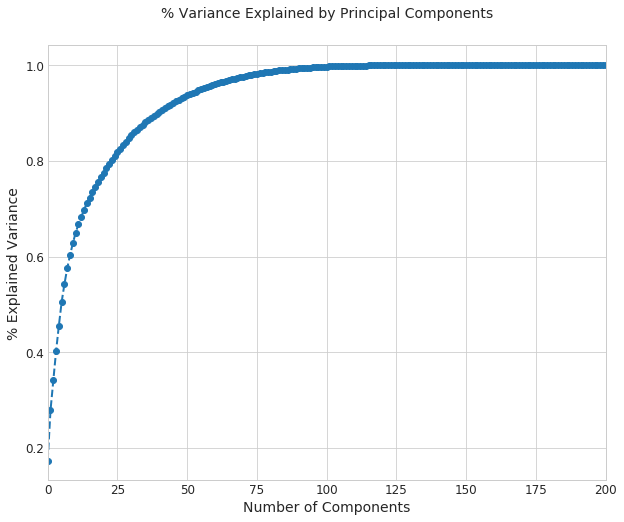

In [45]:
sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [47]:
np.where(np.cumsum(pca.explained_variance_ratio_)>0.95)[0][0]

56

In [48]:
pca=PCA(n_components=56,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 56 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 56 components is: 0.949434396323


In [52]:
X_train=X_pca_21[:36684]
Y_train=fs.iloc[:36684]['Target'].values
X_test=X_pca_21[36684:]
Y_test=fs.iloc[36684:]['Target'].values

## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [53]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,56).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.891069676153
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31688   165    31853
True        3831  1000     4831
__all__    35519  1165    36684

Accuracy of the model for test data is: 0.893698211949
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7935    47     7982
True         928   262     1190
__all__     8863   309     9172



Logistic Regression
Accuracy of the model for training data is: 0.886926180351
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29294  2559    31853
True        1589  3242     4831
__all__    30883  5801    36684

Accuracy of the model for test data is: 0.88552115133
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7335   647     7982
True         403   787     1190
__all__     7738  1434     9172



RandomForest Classifier
Accuracy of the model for training data is: 0.907125722386
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28884  2969    31853
True         438  4393     4831
__all__    29322  7362    36684

Accuracy of the model for test data is: 0.901439162669
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7227   755     7982
True         149  1041     1190
__all__     7376  1796     9172



Adaoost Classifier
Accuracy of the model for training data is: 0.89368662087
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28811  3042    31853
True         858  3973     4831
__all__    29669  7015    36684

Accuracy of the model for test data is: 0.896205843873
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7251   731     7982
True         221   969     1190
__all__     7472  1700     9172



GradientBoosting Classifier
Accuracy of the model for training data is: 0.899847344892
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28894  2959    31853
True         715  4116     4831
__all__    29609  7075    36684

Accuracy of the model for test data is: 0.900457915395
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7258   724     7982
True         189  1001     1190
__all__     7447  1725     9172



ExtraTree Classifier
Accuracy of the model for training data is: 0.908488714426
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28912  2941    31853
True         416  4415     4831
__all__    29328  7356    36684

Accuracy of the model for test data is: 0.89947666812
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7212   770     7982
True         152  1038     1190
__all__     7364  1808     9172



Bagging Classifier
Accuracy of the model for training data is: 0.906744084615
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28890  2963    31853
True         458  4373     4831
__all__    29348  7336    36684

Accuracy of the model for test data is: 0.900021805495
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7216   766     7982
True         151  1039     1190
__all__     7367  1805     9172



Neural Network-1
The accuracy of the model on training data is: 0.896167266383


Predicted  False  True  __all__
Actual                         
False      28716  3137    31853
True         672  4159     4831
__all__    29388  7296    36684

The accuracy of the model on test data is: 0.899040558221


Predicted  False  True  __all__
Actual                         
False       7226   756     7982
True         170  1020     1190
__all__     7396  1776     9172

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [54]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [55]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.891070,1000.0,31688.0,165.0,3831.0,0.005180,0.793004
LogisticRegression,0.886926,3242.0,29294.0,2559.0,1589.0,0.080338,0.328917
RandomForestClassifier,0.907126,4393.0,28884.0,2969.0,438.0,0.093209,0.090664
AdaBoostClassifier,0.893687,3973.0,28811.0,3042.0,858.0,0.095501,0.177603
GradientBoostingClassifier,0.899847,4116.0,28894.0,2959.0,715.0,0.092895,0.148002
ExtraTreeClassifier,0.908489,4415.0,28912.0,2941.0,416.0,0.092330,0.086111
BaggingClassifier,0.906744,4373.0,28890.0,2963.0,458.0,0.093021,0.094804
Neural Network-1,0.896167,4159.0,28716.0,3137.0,672.0,0.098484,0.139102


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.893698,262.0,7935.0,47.0,928.0,0.005888,0.779832,0.607140,0.399063
LogisticRegression,0.885521,787.0,7335.0,647.0,403.0,0.081057,0.338655,0.790144,0.536888
RandomForestClassifier,0.901439,1041.0,7227.0,755.0,149.0,0.094588,0.125210,0.890101,0.660652
AdaBoostClassifier,0.896206,969.0,7251.0,731.0,221.0,0.091581,0.185714,0.861352,0.624953
GradientBoostingClassifier,0.900458,1001.0,7258.0,724.0,189.0,0.090704,0.158824,0.875236,0.645326
ExtraTreeClassifier,0.899477,1038.0,7212.0,770.0,152.0,0.096467,0.127731,0.887901,0.655276
BaggingClassifier,0.900022,1039.0,7216.0,766.0,151.0,0.095966,0.126891,0.888572,0.656820
Neural Network-1,0.899041,1020.0,7226.0,756.0,170.0,0.094713,0.142857,0.888572,0.648350


In [56]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')